In [95]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.animation as animation
import imageio_ffmpeg
from scipy.optimize import curve_fit
my_red = "#f53b3b" # red
my_blue = "#4287f5" # blue

In [96]:
spins = [-1, + 1]


def different_states_indicator(a, b):
    value = (1 - a * b)/2
    return value # 1 = different states, 0 = same state
    
def rho(G, state):
    count = 0
    for edge in list(G.edges()):
        start_node = edge[0]
        end_node = edge[1]
        count += different_states_indicator(state[start_node], state[end_node])
    return count/G.size()

def initial_state(num_nodes):
    states = []
    for node in range(num_nodes):
        states.append(random.choice(spins))
    return states

# ASYNCRONOUS UPDATE: one time step corresponds to 
# updating a number of nodes equal to the network size,
#  N, so that on average (!) every node is updated once
def evolution_step(G, state):
    N = G.number_of_nodes()
    for n in range(N):
        selected_node = random.choice(range(N))
        if G.degree(selected_node) > 0:
            selected_neighbour = random.choice(list(G.neighbors(selected_node)))
            state[selected_node] = state[selected_neighbour]
    return state


# define a Barabasi-Albert graph with node indices sorted by degree in descending order (hubs first)
def ba_graph(num_nodes = 100, mean_degree = 10):
    m = int(mean_degree / 2)
    ba_graph = nx.barabasi_albert_graph(num_nodes, m)
    degrees = dict(ba_graph.degree())
    sorted_indices = sorted(degrees, key=degrees.get, reverse=True)
    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    reindexed_edges = [(new_indices[edge[0]], new_indices[edge[1]]) for edge in ba_graph.edges()]
    reindexed_graph = nx.Graph()
    reindexed_graph.add_edges_from(reindexed_edges) 
    return reindexed_graph


def voter_graph_plot(graph, states, axis):
    colors = []
    for n in range(graph.number_of_nodes()):
        if states[n] == +1:
            colors.append(my_red)
        else:
            colors.append(my_blue)
    positions = nx.spring_layout(graph, seed=42) #by setting the seed, same layout at every run
    nx.draw(graph, ax = axis, pos = positions, node_color = colors, node_size = 5, edge_color = 'lightgrey', width = 0.5)

### First trial and animation of the evolution in a small graph

Text(0, 0.5, 'Node Degree')

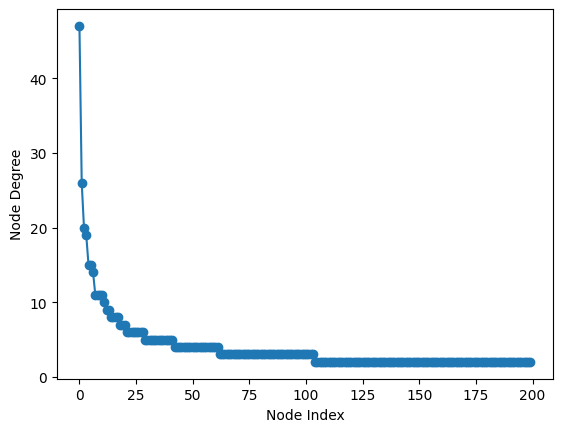

In [19]:
#num_nodes = 10000
#mean_degree = 8
#graph = ba_graph(num_nodes, mean_degree)
#degrees = dict(graph.degree())
#degree_list = [degrees[node] for node in range(num_nodes)]
#fig, ax = plt.subplots()
#ax.plot(range(num_nodes), degree_list, marker='o', linestyle='-')
#ax.set_xlabel('Node Index')
#ax.set_ylabel('Node Degree')

Text(0.5, 1.0, 'Evolution repeated 10 times on the same graph')

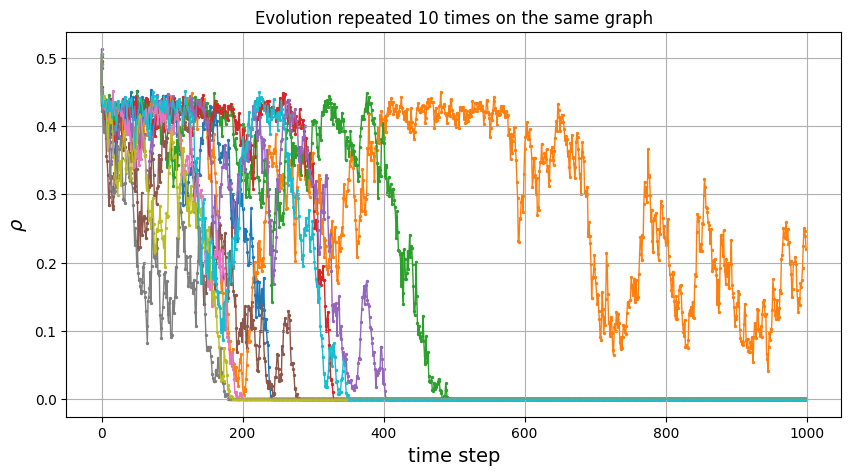

In [77]:
number_of_steps = 1000
num_nodes = 1000
mean_degree = 8
graph = ba_graph(num_nodes, mean_degree)
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    state = initial_state(num_nodes)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_title(f"Evolution repeated {n_realizations} times on the same graph")

Text(0.5, 1.0, 'Evolution repeated only once on 10 different network instances')

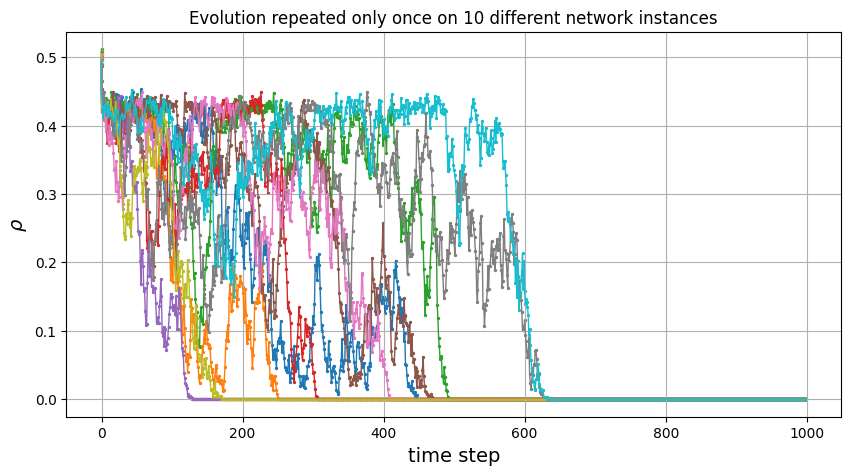

In [84]:
number_of_steps = 1000
num_nodes = 1000
mean_degree = 8
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    graph = ba_graph(num_nodes, mean_degree)
    state = initial_state(num_nodes)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_title(f"Evolution repeated only once on {n_realizations} different network instances")

## Survival time scaling with network size

Question: repeating evolution n times on the same instance of the BA model is the same as repeating evolution exactly once on n different instances?
Might it be that the specific BA instance is somewhat peculiar and does not represent well its ensemble?
I think it is possible.

In [103]:
n_realizations = 1000
mean_degree = 6
network_sizes = [1000, 2000, 5000, 10000, 20000, 50000]
time_steps = 1000
d = {'time' : [t for t in range(time_steps)]} # 0, ..., 499
df = pd.DataFrame(data = d)

for n in range(n_realizations):
    graph = ba_graph(num_nodes= network_sizes[0], mean_degree= mean_degree)
    state = initial_state(num_nodes= network_sizes[0])
    rho_list = []
    for t in range(time_steps):
        state = evolution_step(graph, state)
        rho_list.append(rho(graph, state))
    df[f'instance_{n+1}'] = rho_list
means = []
for index, row in df.iterrows():
    mean = np.mean(row[1:])
    means.append(mean)
df['mean'] = means    
df.to_csv(f"csv_outputs/ensemble_{network_sizes[0]}.csv")

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3704/3934792081.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'instance_{n+1}'] = rho_list
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3704/3934792081.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'instance_{n+1}'] = rho_list
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3704/3934792081.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

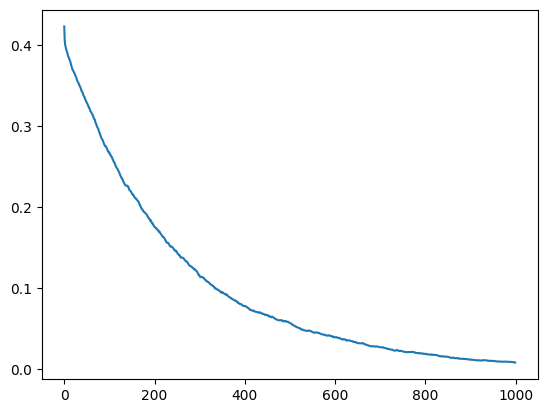

In [105]:
fig, ax = plt.subplots()
ax.plot(df['time'], df['mean'])


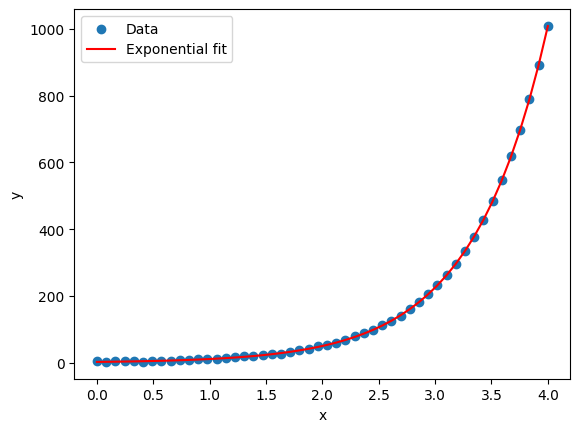

Fitted parameters: a = 2.5042737598197027, b = 1.4993731054381798


In [70]:
np.random.seed(0)
x_data = np.linspace(0, 4, 50)
y_data = 2.5 * np.exp(1.5 * x_data) + np.random.normal(size=x_data.size)

# Step 3: Define the exponential function
def exponential_function(x, a, b):
    return a * np.exp(b * x)

popt, pcov = curve_fit(exponential_function, x_data, y_data, p0=(1, 1))

a_fit, b_fit = popt

# Step 5: Plot the data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, exponential_function(x_data, *popt), color='red', label='Exponential fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Print the fit parameters
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")